In [12]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [13]:
import numpy as np
try:
    import _pickle as cPickle
except:
    import cPickle
import cv2
import tensorflow as tf
import os, time, sys, math, random
from IPython.display import display, clear_output

In [14]:
import matplotlib
%matplotlib notebook
from matplotlib import pyplot as plt
# plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [15]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(length):
    initial = tf.constant(0.1, shape=[length], dtype=tf.float32)
    return tf.Variable(initial)

In [16]:
def createConvulationalLayer(input_data, channel_count, filter_size, filter_count, max_pooling=True):
    shape = [filter_size, filter_size, channel_count, filter_count]
    weights = weight_variable(shape=shape)
    bias = bias_variable(length=filter_count)
    layer = tf.nn.conv2d(input=input_data,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += bias
    if max_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
        layer = tf.layers.dropout(layer, rate=0.25)
    layer = tf.nn.relu(layer)
    return layer, weights

In [17]:
def createFlattenLayer(layer):
    layer_shape = layer.get_shape()
    # layer_shape is assumed to be in shape [number_of_images, image_height, image_width, channels]
    # The channels will be the number of fiter_count in the previous layer
    feature_count = layer_shape[1:4].num_elements()
    # layer_shape[1:4].num_elements()
    flat_layer = tf.reshape(layer, [-1, feature_count])
    return flat_layer, feature_count

In [18]:
def createFullyConnectedLayer(input_data, input_feature_count, output_feature_count, apply_relu=False):
    weights = weight_variable(shape=[input_feature_count, output_feature_count])
    bias = bias_variable(length=output_feature_count)
    layer = tf.matmul(input_data, weights) + bias
    if apply_relu:
        layer = tf.nn.relu(layer)
    return layer

In [19]:
def splitFilenameAndAngle(row):
    filename_and_angle = row.strip().split(',')[0].split()
    result = [filename_and_angle[0], (float(filename_and_angle[1]) * math.pi) / 180]
    return result

In [20]:
def readDataSetInfo(dataset_id='01'):
    info_data = ''
    info_data_dict = {}
    dataset_path = os.path.join('data', 'dataset_' + dataset_id)
    info_file_path = os.path.join(dataset_path, 'data.txt')
    xs = []
    ys = []
    with open(info_file_path, 'r') as f:
        for line in f.readlines():
            filename_and_angle = line.strip().split(',')[0].split()
            x, y = filename_and_angle[0], (float(filename_and_angle[1]) * math.pi) / 180
            xs.append(x)
            ys.append(y)
    
    together = list(zip(xs, ys))
    
    random.shuffle(together)
    filenames, angles = zip(*together)
    
    info_data_dict['path'] = dataset_path
    info_data_dict['filenames'] = filenames
    info_data_dict['angles'] = angles
    return info_data_dict

In [21]:
def readImages(dataset_info, limit=10000, batch_size=40):
    image_data_list = []
    rotation_data_list = []
    for index, filename in enumerate(dataset_info['filenames']):
        image_path = os.path.join(data_info['path'], 'images', filename)
        image_data = cv2.imread(image_path)
        image_data = cv2.resize(image_data, (0,0), fx=0.4, fy=0.4)
        image_data_list.append(image_data)
        rotation_data_list.append(dataset_info['angles'][index])
        if len(image_data_list) == batch_size:
            if batch_size == 1:
                image_data_list, rotation_data_list = image_data_list[0], rotation_data_list[0]
            yield np.array(image_data_list), np.array(rotation_data_list).reshape(-1, 1)
            image_data_list = []
            rotation_data_list = []
        
    if image_data_list:
        yield np.array(image_data_list), np.array(rotation_data_list).reshape(-1, 1)

In [22]:
def preprocessData(x):
    mu = np.mean(x, axis=(0, 1, 2), keepdims=1)
    sigma = np.std(x, axis=(0, 1, 2), keepdims=1)
    x = x - mu
    x = x / sigma
    return x

In [23]:
data_info = readDataSetInfo()

In [24]:
a = None
b = None
for x, y in readImages(data_info):
    a = preprocessData(x)
    b = y
    break

In [25]:
a.shape

(40, 102, 182, 3)

In [26]:
sample_image, sample_rotation = readImages(data_info, batch_size=1).next()
# plt.imshow(a[3])

In [27]:
sample_image.shape

(102, 182, 3)

In [28]:
image_height = sample_image.shape[0]
image_width = sample_image.shape[1]
image_depth = sample_image.shape[2]

In [29]:
image_height * image_width * image_depth

55692

In [30]:
filter_size_2 = 2
filter_size_3 = 3
filter_size_5 = 5
filter_count_24 = 24
filter_count_32 = 32
filter_count_36 = 36
filter_count_48 = 48
filter_count_64 = 64
filter_count_128 = 128

fully_conn_layer_1_out_size = 100
fully_conn_layer_2_out_size = 50
fully_conn_layer_3_out_size = 10
fully_conn_layer_4_out_size = 1

In [31]:
x = tf.placeholder(tf.float32, shape=[None, image_height, image_width, image_depth])
y_actual = tf.placeholder(tf.float32, shape=(None, 1))

In [32]:
conv_layer_1, conv_weights_1 = createConvulationalLayer(input_data=x,
                   channel_count=image_depth,
                   filter_size=filter_size_5,
                   filter_count=filter_count_24,
                   max_pooling=False)

In [33]:
conv_layer_2, conv_weights_2 = createConvulationalLayer(input_data=conv_layer_1,
                   channel_count=filter_count_24,
                   filter_size=filter_size_5,
                   filter_count=filter_count_36,
                   max_pooling=True)

In [34]:
conv_layer_3, conv_weights_3 = createConvulationalLayer(input_data=conv_layer_2,
                   channel_count=filter_count_36,
                   filter_size=filter_size_5,
                   filter_count=filter_count_48,
                   max_pooling=False)

In [35]:
conv_layer_4, conv_weights_4 = createConvulationalLayer(input_data=conv_layer_3,
                   channel_count=filter_count_48,
                   filter_size=filter_size_3,
                   filter_count=filter_count_64,
                   max_pooling=True)

In [36]:
conv_layer_5, conv_weights_5 = createConvulationalLayer(input_data=conv_layer_4,
                   channel_count=filter_count_64,
                   filter_size=filter_size_3,
                   filter_count=filter_count_64,
                   max_pooling=False)

In [37]:
flat_layer, num_features = createFlattenLayer(conv_layer_5)

In [38]:
fully_con_layer_1 = createFullyConnectedLayer(input_data=flat_layer,
                         input_feature_count=num_features,
                         output_feature_count=fully_conn_layer_1_out_size,
                         apply_relu=True)

In [39]:
fully_con_layer_2 = createFullyConnectedLayer(input_data=fully_con_layer_1,
                         input_feature_count=fully_conn_layer_1_out_size,
                         output_feature_count=fully_conn_layer_2_out_size,
                         apply_relu=True)

In [40]:
fully_con_layer_3 = createFullyConnectedLayer(input_data=fully_con_layer_2,
                         input_feature_count=fully_conn_layer_2_out_size,
                         output_feature_count=fully_conn_layer_3_out_size,
                         apply_relu=False)

In [41]:
fully_con_layer_4 = createFullyConnectedLayer(input_data=fully_con_layer_3,
                         input_feature_count=fully_conn_layer_3_out_size,
                         output_feature_count=fully_conn_layer_4_out_size,
                         apply_relu=False)

In [42]:
y_predicted = fully_con_layer_4 # tf.nn.softmax(fully_con_layer_4)
cross_entropy = tf.reduce_mean(tf.square(tf.subtract(y_actual, y_predicted)))
# cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_actual * tf.log(y_predicted), reduction_indices=[1]))
optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [43]:
is_correct = tf.equal(tf.argmax(y_predicted, 1), tf.argmax(y_actual, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

In [44]:
epochs = 20
session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
session.run(init)

In [45]:
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, os.path.join("model", "model.ckpt"))

INFO:tensorflow:Restoring parameters from model/model.ckpt


In [51]:
def predict(images, actual_value=''):
    test_data = {x: images}
    predicted_value = sess.run(y_predicted, feed_dict=test_data)
    return predicted_value
#     for i in range(len(predicted_value)):
#         print str(predicted_value[i]).ljust(15)+ str(actual_value[i]).ljust(15)
        

In [52]:
data_info = readDataSetInfo()
val = []
for images, angles in readImages(data_info):
    images = preprocessData(images)
    val = predict(images, angles)
    break

In [58]:
val.flatten()

array([  1.18402854e-01,   2.06299499e-02,   3.73951346e-03,
         1.85121186e-02,  -3.65100414e-01,   2.78236568e-02,
         3.28908026e-01,   4.28559208e+00,   4.36299920e-01,
         2.95086503e-02,  -8.71597156e-02,  -5.46658114e-02,
         6.71089441e-03,   1.40425786e-02,   1.49469048e-01,
         2.13460624e-02,  -1.45595312e-01,   3.69386375e-03,
         6.69297054e-02,  -1.47496387e-02,   1.58441514e-01,
         7.57499561e-02,   2.98003182e-02,   1.30685896e-01,
         9.67861056e-01,   4.49388027e-02,  -2.61341557e-02,
         5.16422167e-02,   2.21828148e-02,   4.09824029e-02,
         8.25465396e-02,  -1.24645638e+00,  -1.50317383e+00,
         1.65159479e-02,  -1.67798758e-01,   2.21756005e+00,
        -1.33483022e-01,   4.92912456e-02,   1.48906559e-01,
        -2.40715116e-01], dtype=float32)

In [4]:
def rotateImage(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [9]:
import time

<IPython.core.display.Javascript object>


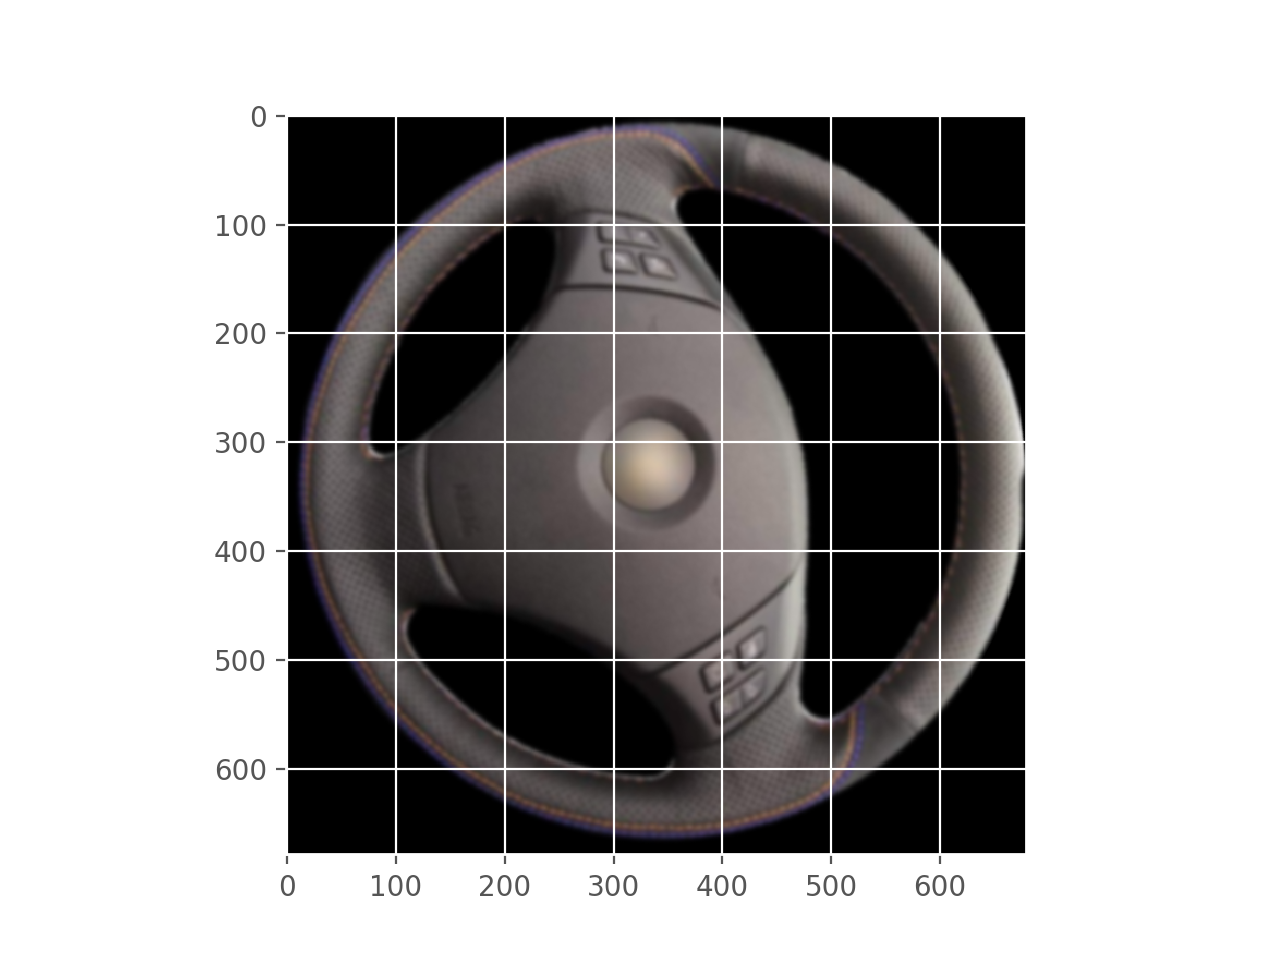

In [11]:
wheel = cv2.imread('data/wheel.png')
for i in range(30):
    wheel = rotateImage(wheel, -i)
    plt.imshow(wheel)
    plt.show()
    time.sleep(1)